In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA 
from xgboost import XGBClassifier
# from xgboost.sklearn import XGBClassifier
# Regression Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
# subsample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
# clustering
from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
# Ignore ConvergenceWarning messages
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train = pd.read_csv('train.csv')
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,NAME_YIELD_GROUP,NFLAG_INSURED_ON_APPROVAL,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,Diff_applied_apprved,Days_consumerloans,AMT_credit_consumerloans,Days_cashloans,AMT_credit_cashloans,Days_revolvingloans,AMT_credit_revolvingloans,MONTHS_BALANCE0_x,balance_pct_change0,MONTHS_BALANCE1_x,balance_pct_change1,MONTHS_BALANCE2_x,balance_pct_change2,MONTHS_BALANCE3_x,balance_pct_change3,has_cc_now,balance_now,times_bal80,DAYS_INSTALMENT_first,insta_debt_sum,insta_debt_mean,insta_debt_first,insta_delinquency_sum,insta_delinquency_first,MONTHS_BALANCE0_y,SK_DPD0,SK_DPD_DEF0,MONTHS_BALANCE1_y,SK_DPD1,SK_DPD_DEF1,MONTHS_BALANCE2_y,SK_DPD2,SK_DPD_DEF2,MONTHS_BALANCE3_y,SK_DPD3,SK_DPD_DEF3
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,0.0,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,low_normal,0.0,1.0,1.0,0.0,-606.0,179055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-25.0,0.000,0.000000,0.0,0.0,0.0,-13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,0.0,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,low_normal,1.0,1.0,1.0,-135882.0,-828.0,348637.5,-746.0,1035882.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-536.0,0.000,0.000000,0.0,0.0,0.0,-23.0,0.0,0.0,-66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,middle,0.0,1.0,1.0,4176.0,-815.0,20106.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-724.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,0.0,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,XNA,0.0,1.0,1.0,0.0,-311.0,267930.0,-181.0,675000.0,-181.0,270000.0,-1.0,0.0,-2.0,0.0,-5.0,0.0,0.0,0.0,1.0,0.0,0.0,-11.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,0.0,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,middle,1.0,1.0,1.0,-26788.5,-1768.0,30663.0,-374.0,274288.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-14.0,29857.365,452.384318,0.0,16.0,0.0,-3.0,0.0,0.0,-9.0,0.0,0.0,-10.0,0.0,0.0,-35.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,22

In [5]:
train = train[:30000]

In [6]:
corr = train.corr()
corr

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,AMT_DOWN_PAYMENT,NFLAG_INSURED_ON_APPROVAL,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,Diff_applied_apprved,Days_consumerloans,AMT_credit_consumerloans,Days_cashloans,AMT_credit_cashloans,Days_revolvingloans,AMT_credit_revolvingloans,MONTHS_BALANCE0_x,balance_pct_change0,MONTHS_BALANCE1_x,balance_pct_change1,MONTHS_BALANCE2_x,balance_pct_change2,MONTHS_BALANCE3_x,balance_pct_change3,has_cc_now,balance_now,times_bal80,DAYS_INSTALMENT_first,insta_debt_sum,insta_debt_mean,insta_debt_first,insta_delinquency_sum,insta_delinquency_first,MONTHS_BALANCE0_y,SK_DPD0,SK_DPD_DEF0,MONTHS_BALANCE1_y,SK_DPD1,SK_DPD_DEF1,MONTHS_BALANCE2_y,SK_DPD2,SK_DPD_DEF2,MONTHS_BALANCE3_y,SK_DPD3,SK_DPD_DEF3
SK_ID_CURR,1.000000,0.007744,-0.001455,-0.000654,0.003041,0.005662,0.002209,-0.004858,-0.009322,0.009026,-0.000249,-0.003878,0.010173,-0.000495,-0.009109,-0.007037,-0.010035,-0.009837,0.001493,-0.003405,0.007981,0.006469,-0.005017,-0.002772,-0.003416,-0.003510,0.005746,-0.000436,0.000278,-0.004549,-0.001920,0.003951,-0.004724,-0.008031,-0.007334,-0.007374,-0.002905,-0.001145,-0.007341,-0.007634,...,0.005429,0.013025,-0.002954,-0.006463,-0.001442,0.006676,0.007259,0.001162,-0.004637,0.002431,0.000066,-0.000402,0.000991,-0.003150,-0.004616,0.002659,0.002456,-0.000991,0.002681,-0.004275,0.005136,0.002141,0.001840,0.012552,0.010596,0.001414,0.010468,0.006123,0.000632,-0.008174,0.004619,-0.003951,-0.009747,-0.005554,-0.000194,-0.009384,0.007237,0.003510,-0.009674,0.004300
TARGET,0.007744,1.000000,0.029367,0.015757,-0.030833,-0.005955,-0.038015,-0.037547,0.080900,-0.038866,0.046820,0.044953,0.002659,0.001704,0.040055,0.019799,0.008758,-0.032693,0.001949,0.014138,0.067410,0.067844,-0.028740,0.011030,0.003536,-0.002744,0.035978,0.045125,0.027343,-0.061918,-0.151376,-0.124235,-0.030688,-0.025510,-0.042524,-0.033028,-0.011958,-0.032178,-0.030927,-0.047031,...,-0.020820,-0.005693,0.014260,0.017778,-0.008940,0.013406,-0.025493,0.010028,-0.011680,0.002244,0.009755,-0.008637,0.018294,-0.011439,0.015308,-0.012198,0.004411,-0.002797,0.009511,0.020094,0.035445,0.018644,-0.009406,0.020459,0.025645,0.017203,0.039928,0.037893,0.003140,0.001439,0.026471,0.016034,0.000863,0.030678,0.020796,-0.000585,0.011180,0.015439,-0.000886,0.005683
CNT_CHILDREN,-0.001455,0.029367,1.000000,0.009225,0.007826,0.027320,0.002077,-0.025130,0.333169,-0.239023,0.185986,-0.031794,0.076884,0.003326,0.240100,0.052291,-0.003042,-0.030721,0.024376,0.880267,0.023691,0.022555,-0.008350,-0.012550,0.004802,0.013155,0.023274,0.069142,0.064820,0.043737,-0.021585,-0.008107,-0.037415,-0.028202,-0.034406,-0.022191,-0.016589,-0.031775,-0.033458,-0.038814,...,0.013427,-0.034040,0.015144,0.026705,0.029304,0.028495,0.005013,0.036069,-0.054420,0.008109,-0.002044,0.005324,-0.006904,0.006726,0.000798,0.014691,-0.001356,0.016574,-0.003493,0.003750,0.012361,-0.008758,-0.013674,0.013411,0.008414,0.004862,0.006304,0.004671,-0.037058,0.012729,0.004354,-0.035588,0.012249,-0.001842,-0.025034,0.013668,0.020299,-0.011820,0.012169,0.005663
AMT_INCOME_TOTAL,-0.000654,0.015757,0.009225,1.000000,0.054326,0.065253,0.054552,0.021496,0.014295,-0.025321,0.005405,0.001349,0.004846,0.000392,0.025302,-0.009113,-0.002134,-0.003362,0.011617,0.010835,-0.030339,-0.032175,0.015925,0.010403,0.021404,0.019647,0.000006,-0.001052,-0.000325,0.017852,0.010380,-0.004787,0

In [7]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
to_drop

['AMT_GOODS_PRICE',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LIVINGAPARTMENTS_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'AMT_defaulted_mean',
 'AMT_defaulted3',
 'STATUS_0',
 'SK_DPD2']

In [8]:
train = train.drop(to_drop, axis=1)

In [9]:
train['OCCUPATION_TYPE'].value_counts()/len(train) 
train['OCCUPATION_TYPE'].unique()
train['OCCUPATION_TYPE'].replace([ 'Cleaning staff', 'Cooking staff', 'Accountants', 'Medicine staff'
        'Private service staff', 'Security staff','Waiters/barmen staff',
        'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff', 'HR staff'], 'Others', inplace= True)
train['ORGANIZATION_TYPE'].value_counts()/len(train) 
train['ORGANIZATION_TYPE'].replace(['School', 'Religion',
       'Other','Electricity', 'Medicine',
       'Transport: type 2',
       'Construction', 'Housing', 'Kindergarten', 'Trade: type 7',
       'Industry: type 11', 'Military', 'Services', 'Security Ministries',
       'Transport: type 4', 'Industry: type 1', 'Emergency', 'Security',
       'Trade: type 2', 'University', 'Transport: type 3', 'Police',
       'Business Entity Type 1', 'Postal', 'Industry: type 4',
       'Agriculture', 'Restaurant', 'Culture', 'Hotel',
       'Industry: type 7', 'Trade: type 3', 'Industry: type 3', 'Bank',
       'Industry: type 9', 'Insurance', 'Trade: type 6',
       'Industry: type 2', 'Transport: type 1', 'Industry: type 12',
       'Mobile', 'Trade: type 1', 'Industry: type 5', 'Industry: type 10',
       'Legal Services', 'Advertising', 'Trade: type 5', 'Cleaning',
       'Industry: type 13', 'Trade: type 4', 'Telecom',
       'Industry: type 8', 'Realtor', 'Industry: type 6'], 'Others', inplace = True)
train.describe() #outlier: max(days_Employed)
outlier = train[train['DAYS_EMPLOYED'] == 365243]
outlier['TARGET'].value_counts()/len(outlier)
train['DAYS_EMPLOYED'].describe()
train['TARGET'].value_counts()/len(train) # Outlier had lower rate of default (target = 1)

0    0.9199
1    0.0801
Name: TARGET, dtype: float64

In [10]:
# train['Days_employed_outlier'] = train['DAYS_EMPLOYED'] == 365243
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True) # replace outlier by 
train['DAYS_EMPLOYED'].fillna(np.mean(train['DAYS_EMPLOYED']), inplace= True) # fill na with by mean of the column

In [11]:
# Feature engineering
train['Credit_income_ratio'] = train['AMT_CREDIT']/train['AMT_INCOME_TOTAL']
train['Anuity_income_ratio'] = train['AMT_ANNUITY']/train['AMT_INCOME_TOTAL'] 
train['Credit_term'] = train['AMT_ANNUITY']/train['AMT_CREDIT'] #length of the payment in months since the annuity is the monthly amount due
train['Days_employed_age'] = train['DAYS_EMPLOYED']/train['DAYS_BIRTH']

In [12]:
corr = train.corr()['TARGET'].sort_values()
corr.head(10)

EXT_SOURCE_2                  -0.151376
EXT_SOURCE_3                  -0.124235
EXT_SOURCE_1                  -0.061918
Days_employed_age             -0.061045
FLOORSMAX_AVG                 -0.047031
ratio_approved                -0.046577
YEARS_BEGINEXPLUATATION_AVG   -0.042524
REGION_POPULATION_RELATIVE    -0.037547
TOTALAREA_MODE                -0.035045
FLOORSMIN_AVG                 -0.034261
Name: TARGET, dtype: float64

In [13]:
corr.tail()

DAYS_EMPLOYED       0.075593
DAYS_BIRTH          0.080900
ratio_refused       0.091530
TARGET              1.000000
FLAG_DOCUMENT_12         NaN
Name: TARGET, dtype: float64

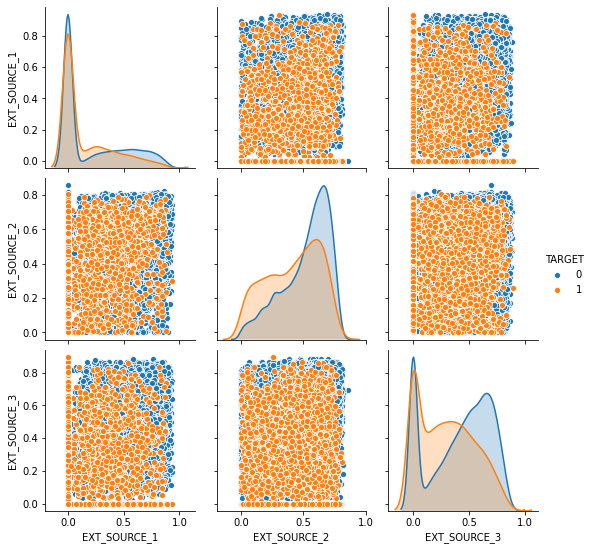

In [14]:
cols = ['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
sns.pairplot(train[cols][:30000], height = 2.5, hue='TARGET')
plt.show()

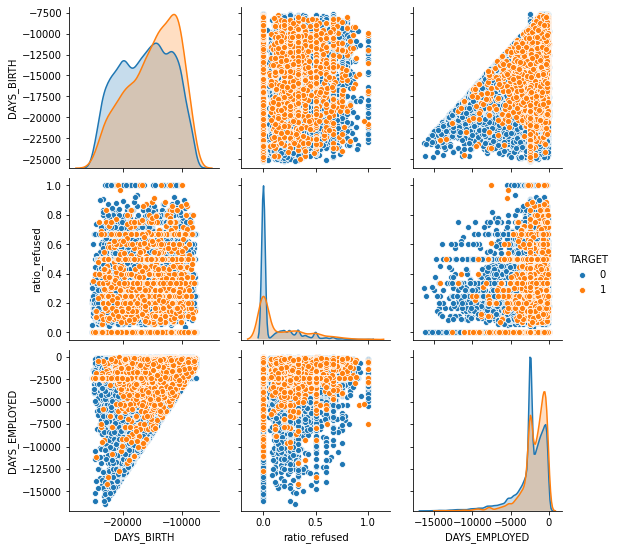

In [15]:
cols = ['TARGET','DAYS_BIRTH', 'ratio_refused', 'DAYS_EMPLOYED']
sns.pairplot(train[cols][:30000], height = 2.5, hue= 'TARGET')
plt.show()

In [16]:
train = pd.get_dummies(train, drop_first=True)

In [17]:
train['TARGET'].value_counts() 

0    27597
1     2403
Name: TARGET, dtype: int64

In [18]:
y = train['TARGET']
X = train.drop('TARGET', axis=1)

In [19]:
# sc = StandardScaler()
# X_pca = sc.fit_transform(X)
# pca = PCA(n_components = 175)
# X_pca = pca.fit_transform(X_pca)
# sum(pca.explained_variance_ratio_)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state=1234)
# SMOTE: SMOTE oversampling of minority class to 50% and random undersampling of majority to 50%
over  = SMOTE(sampling_strategy = 0.5)
under = RandomUnderSampler(sampling_strategy = 1)
sc = StandardScaler()
pca = PCA(n_components = 175)
xgb = XGBClassifier()
pipeline = Pipeline(steps = [('o', over), ('u', under), ('scale', sc), ('pca', pca), ('xgbclassifier', xgb)])
params = {
    'xgbclassifier__learning_rate': [0.1], #[0.05, 0.1, 0.15, 0.2]
    'xgbclassifier__max_depth': [3], # [3, 4, 5, 6, 8, 10 ]
    'xgbclassifier__min_child_weight': [1], # [1, 3, 5, 7] "stop trying to split once your sample size in a node goes below a given threshold".
    'xgbclassifier__gamma' : [0.1], #[0, 0.1, 0.2, 0.3, 0.4],   #minimum loss reduction required to make a split.
    'xgbclassifier__colsample_bytree': [0.7] #[ 0.5, 0.7, 1]            
}
model = GridSearchCV(pipeline, params, cv=5, n_jobs=-1)
model.fit(X_train, y_train)
model.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7507499999999999

In [21]:
# pipeline.get_params()

In [22]:
from sklearn.metrics import accuracy_score
pred_class = model.predict(X_test)
print( 'XGBoost accuracy:', accuracy_score(y_test, pred_class))

XGBoost accuracy: 0.7406666666666667


In [23]:
# Class Probabilities
pred = model.predict_proba(X_test)
pred = [p[1] for p in pred] # Positive class (1) probabilities

In [24]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix
print( confusion_matrix(y_test, pred_class) )
cm = confusion_matrix(y_test, pred_class)
# True Positives (TP)
tp = cm[1][1]
# False Positives (FP)
fp = cm[0][1]
# True Negatives (TN)
tn = cm[0][0]
# False Negatives (FN)
fn = cm[1][0]
precision = tp / (tp + fp)
print( 'Precision:', precision )
recall = tp / (tp + fn)
print( 'Recall', recall )

[[4217 1308]
 [ 248  227]]
Precision: 0.14788273615635178
Recall 0.47789473684210526


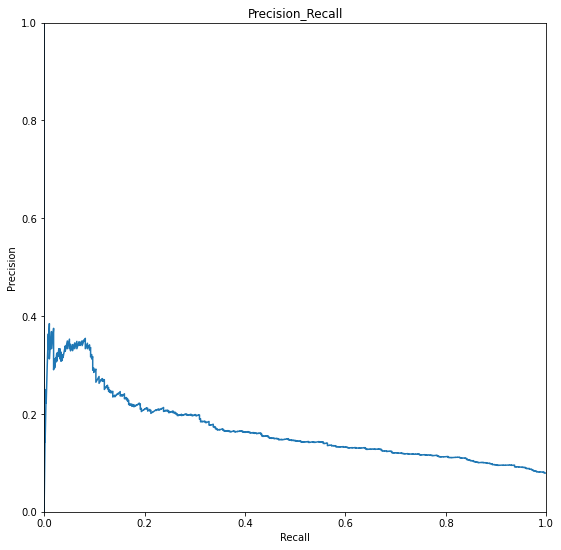

In [25]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, pred)
# pd.DataFrame({'precision': precision, 'recall' : recall})
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Precision_Recall')

# Plot Precision-Recall curve
plt.plot(recall, precision)

# Axes limits and labels
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [26]:
# Classification metrics
from sklearn.metrics import roc_curve, roc_auc_score
# Calculate ROC curve from y and pred
fpr, tpr, thresholds = roc_curve(y_test, pred)
f1score = 2*(tpr+fpr)/(tpr*fpr)
precision = tpr / (tpr + fpr)
recall = tpr
pd.DataFrame({'Precision': precision, 'Recall' : tpr, 'F1SCORE': f1score, 'Thresholds' : thresholds})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


,Precision,Recall,F1SCORE,Thresholds
0,NaN,0.000000,NaN,1.859125
1,0.000000,0.000000,inf,0.859125
2,0.000000,0.000000,inf,0.836941
3,0.699367,0.002105,3160.000000,0.834511
4,0.659701,0.002105,2791.666667,0.830418
...,...,...,...,...
829,0.499806,0.995789,4.015358,0.043059
830,0.500334,0.997895,4.011121,0.042858
831,0.500017,0.997895,4.008573,0.036239
832,0.500544,1.000000,4.004353,0.035474


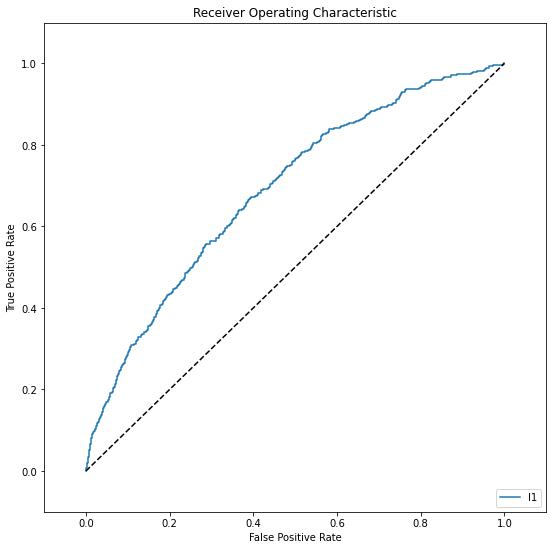

In [27]:
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [28]:
# AUROC
roc_auc_score(y_test, pred)

0.6882488211478924

In [29]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa = cohen_kappa_score(y_test, pred_class)
cohen_kappa

0.11939066663522535